#COMP 565 Assignment 3 - Exploring genome language models with HyenaDNA

This notebook is adapted from the Colab notebook available at https://github.com/HazyResearch/hyena-dna.

In this assignment, you will directly modify the code blocks as instructed below (look for **A3 task xx **) to perform the following tasks:

1.   Train on the GenomicBenchmarks dataset from scratch and fine-tune (sequence level classification tasks)
2.   Do inference on sequences to examine the sequence embedding via t-SNE visualization
3.   Implement next token prediction

Open the "Table of contents" on the left to help you navigate the codeblocks and identify the ones that require modifications.

For the rest of the codeblocks, simply click through them **without making any change**. You are encouraged to read and understand each codeblock. But we will only grade the assigned code blocks and the desired outputs.

You are recommended to run the code using Colab. By the default Colab connects to a CPU node. To speed up the training, you may connect with a T4 GPU by choosing 'Runtime' in the top menu and then clicking on 'Change runtime type' and choose 'T4 GPU'. Note that for free Google account, we can keep the notebook connected to a GPU for at most 12 hours. Nonetheless, all the training and inference required to complete this assignment can be done within 5 minutes even with a CPU.

#Deliverabe
Submit your completed notebook to MyCourses.

#Late submission policy
For late submission, $2^k$ percent will be deducted per $k$ days of the delay.
To use your 6-day quota as a team, submit your request by emailing Liam Hodgson (liam.hodgson@mcgill.ca) with subject title ``Assignment 3 extension request" and in the email body specify the number of days (max at 6 days) you need to submit your assignment. You can only submit the request ONCE. Therefore, plan and use your quota wisely.

In [ ]:
#@title Installs
!pip install einops
!pip install torchvision
!pip install transformers==4.26.1
!pip install genomic-benchmarks
!pip install OmegaConf
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.1 MB/s eta 0:00:00
  Created wheel for genomic-benchmarks: filename=genomic_benchmarks-0.0.9-py3-none-any.whl size=22506 sha256=a671c7eae73e90128c9f2ceea438ac0275bef717cee988c183198dfb9c302b47
  Stored in directory: /root/.cache/pip/wheels/86/78/72/de9d75be800b6d679b8814b9663b3f610c34188b443b8b9b77
Successfully bu

In [ ]:
#@title Imports
# for HyenaDNA specifically
import torch
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from einops import rearrange
from typing import Optional
from functools import partial
from torch import Tensor
from torchvision.ops import StochasticDepth
from collections import namedtuple

# HyenaDNA



In [ ]:
#@title Hyena layer


def fftconv(u, k, D):
    """
    We apply a convolution through the fourier domain (from the Convolution Theorem)

    """
    seqlen = u.shape[-1]
    fft_size = 2 * seqlen

    k_f = torch.fft.rfft(k, n=fft_size) / fft_size
    u_f = torch.fft.rfft(u.to(dtype=k.dtype), n=fft_size)

    if len(u.shape) > 3: k_f = k_f.unsqueeze(1)
    y = torch.fft.irfft(u_f * k_f, n=fft_size, norm='forward')[..., :seqlen]

    out = y + u * D.unsqueeze(-1)
    return out.to(dtype=u.dtype)


@torch.jit.script
def mul_sum(q, y):
    return (q * y).sum(dim=1)

class OptimModule(nn.Module):
    """ Interface for Module that allows registering buffers/parameters with configurable optimizer hyperparameters """

    def register(self, name, tensor, lr=None, wd=0.0):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {}
            if lr is not None: optim["lr"] = lr
            if wd is not None: optim["weight_decay"] = wd
            setattr(getattr(self, name), "_optim", optim)


class Sin(nn.Module):
    """The Sin activation function for the Hyena Filter function."""
    def __init__(self, dim, w=10, train_freq=True):
        super().__init__()
        self.freq = nn.Parameter(w * torch.ones(1, dim)) if train_freq else w * torch.ones(1, dim)

    def forward(self, x):
        return torch.sin(self.freq * x)


class PositionalEmbedding(OptimModule):
    def __init__(self, emb_dim: int, seq_len: int, lr_pos_emb: float=1e-5, **kwargs):
        """Complex exponential positional embeddings for Hyena filters."""
        super().__init__()

        self.seq_len = seq_len
        # The time embedding fed to the filteres is normalized so that t_f = 1
        t = torch.linspace(0, 1, self.seq_len)[None, :, None] # 1, L, 1

        if emb_dim > 1:
            bands = (emb_dim - 1) // 2
        # To compute the right embeddings we use the "proper" linspace
        t_rescaled = torch.linspace(0, seq_len - 1, seq_len)[None, :, None]
        w = 2 * math.pi * t_rescaled / seq_len # 1, L, 1

        f = torch.linspace(1e-4, bands - 1, bands)[None, None]
        z = torch.exp(-1j * f * w)
        z = torch.cat([t, z.real, z.imag], dim=-1)
        self.register("z", z, lr=lr_pos_emb)
        self.register("t", t, lr=0.0)

    def forward(self, L):
        return self.z[:, :L], self.t[:, :L]


class ExponentialModulation(OptimModule):
    """The window function applied to the output of the (MLP) filter function."""
    def __init__(
        self,
        d_model,
        fast_decay_pct=0.3,
        slow_decay_pct=1.5,
        target=1e-2,
        modulation_lr=0.0,
        modulate: bool=True,
        shift: float = 0.05,
        **kwargs
    ):
        super().__init__()
        self.modulate = modulate
        self.shift = shift
        max_decay = math.log(target) / fast_decay_pct
        min_decay = math.log(target) / slow_decay_pct
        deltas = torch.linspace(min_decay, max_decay, d_model)[None, None]
        self.register("deltas", deltas, lr=modulation_lr)

    def forward(self, t, x):
        if self.modulate:
            decay = torch.exp(-t * self.deltas.abs())
            x = x * (decay + self.shift)
        return x


class HyenaFilter(OptimModule):
    def __init__(
            self,
            d_model,
            emb_dim=3, # dim of input to MLP, augments with positional encoding
            order=16, # width of the implicit MLP
            fused_fft_conv=False,
            seq_len=1024,
            lr=1e-3,
            lr_pos_emb=1e-5,
            dropout=0.0,
            w=1, # frequency of periodic activations
            wd=0, # weight decay of kernel parameters
            bias=True,
            num_inner_mlps=2,
            normalized=False,
            **kwargs
        ):
        """
        Implicit long filter with modulation.

        Args:
            d_model: number of channels in the input
            emb_dim: dimension of the positional encoding (`emb_dim` - 1) // 2 is the number of bands
            order: width of the FFN
            num_inner_mlps: number of inner linear layers inside filter MLP

        Note:
            filter_dropout is not implemented
        """
        super().__init__()

        self.d_model = d_model
        self.use_bias = bias
        self.fused_fft_conv = fused_fft_conv
        self.bias = nn.Parameter(torch.randn(self.d_model))
        self.dropout = nn.Dropout(dropout)

        act = Sin(dim=order, w=w)
        self.emb_dim = emb_dim
        assert emb_dim % 2 != 0 and emb_dim >= 3, "emb_dim must be odd and greater or equal to 3 (time, sine and cosine)"
        self.seq_len = seq_len

        self.pos_emb = PositionalEmbedding(emb_dim, seq_len, lr_pos_emb)

        self.implicit_filter = nn.Sequential(
            nn.Linear(emb_dim, order),
            act,
        )
        for i in range(num_inner_mlps):
            self.implicit_filter.append(nn.Linear(order, order))
            self.implicit_filter.append(act)

        self.implicit_filter.append(nn.Linear(order, d_model, bias=False))

        self.modulation = ExponentialModulation(d_model, **kwargs)

        self.normalized = normalized
        for c in self.implicit_filter.children():
            for name, v in c.state_dict().items():
                optim = {"weight_decay": wd, "lr": lr}
                setattr(getattr(c, name), "_optim", optim)

    def filter(self, L, *args, **kwargs):
        z, t = self.pos_emb(L)
        h = self.implicit_filter(z)
        h = self.modulation(t, h)
        return h

    def forward(self, x, L, k=None, bias=None, *args, **kwargs):
        if k is None: k = self.filter(L)

        # Ensure compatibility with filters that return a tuple
        k = k[0] if type(k) is tuple else k

        y = fftconv(x, k, bias)
        return y


class HyenaOperator(nn.Module):
    def __init__(
            self,
            d_model,
            l_max,
            order=2,
            filter_order=64,
            dropout=0.0,
            filter_dropout=0.0,
            **filter_args,
        ):
        r"""
        Hyena operator described in the paper https://arxiv.org/pdf/2302.10866.pdf

        Args:
            d_model (int): Dimension of the input and output embeddings (width of the layer)
            l_max: (int): Maximum input sequence length. Defaults to None
            order: (int): Depth of the Hyena recurrence. Defaults to 2
            dropout: (float): Dropout probability. Defaults to 0.0
            filter_dropout: (float): Dropout probability for the filter. Defaults to 0.0
        """
        super().__init__()

        self.d_model = d_model
        self.l_max = l_max
        self.order = order
        inner_width = d_model * (order + 1)
        self.dropout = nn.Dropout(dropout)
        self.in_proj = nn.Linear(d_model, inner_width)
        self.out_proj = nn.Linear(d_model, d_model)

        self.short_filter = nn.Conv1d(
            inner_width,
            inner_width,
            3,
            padding=2,
            groups=inner_width
        )
        self.filter_fn = HyenaFilter(
            d_model * (order - 1),
            order=filter_order,
            seq_len=l_max,
            channels=1,
            dropout=filter_dropout,
            **filter_args
        )

    def forward(self, u, *args, **kwargs):
        l = u.size(-2)
        l_filter = min(l, self.l_max)
        u = self.in_proj(u)
        u = rearrange(u, 'b l d -> b d l')

        uc = self.short_filter(u)[...,:l_filter]
        *x, v = uc.split(self.d_model, dim=1)

        k = self.filter_fn.filter(l_filter)[0]
        k = rearrange(k, 'l (o d) -> o d l', o=self.order - 1)
        bias = rearrange(self.filter_fn.bias, '(o d) -> o d', o=self.order - 1)

        for o, x_i in enumerate(reversed(x[1:])):
            v = self.dropout(v * x_i)
            v = self.filter_fn(v, l_filter, k=k[o], bias=bias[o])

        y = rearrange(v * x[0], 'b d l -> b l d')

        y = self.out_proj(y)
        return y


In [ ]:
#@title Self-Attention (alternative)

"""
If you'd like to try the HyenaDNA model using attention instead, you can. ie,
use a regular decoder only Transformer.

Borrowed from the FlashAttention library by Tri Dao.
"""

class SelfAttention(nn.Module):
    """Implement the scaled dot product attention with softmax.
    Arguments
    ---------
        softmax_scale: The temperature to use for the softmax attention.
                      (default: 1/sqrt(d_keys) where d_keys is computed at
                      runtime)
        attention_dropout: The dropout rate to apply to the attention
                           (default: 0.0)
    """
    def __init__(self, causal=False, softmax_scale=None, attention_dropout=0.0):
        super().__init__()
        self.causal = causal
        self.softmax_scale = softmax_scale
        self.dropout_p = attention_dropout

    def forward(self, qkv, causal=None, key_padding_mask=None):
        """Implements the multihead softmax attention.
        Arguments
        ---------
            qkv: The tensor containing the query, key, and value. (B, S, 3, H, D)
            causal: if passed, will override self.causal
            key_padding_mask: boolean mask to apply to the attention weights. True means to keep,
                False means to mask out. (B, S)
        """
        batch_size, seqlen = qkv.shape[0], qkv.shape[1]
        causal = self.causal if causal is None else causal
        q, k, v = qkv.unbind(dim=2)
        softmax_scale = self.softmax_scale or 1.0 / math.sqrt(q.shape[-1])
        scores = torch.einsum('bthd,bshd->bhts', q, k * softmax_scale)
        if key_padding_mask is not None:
            padding_mask = torch.full((batch_size, seqlen), -10000.0, dtype=scores.dtype,
                                      device=scores.device)
            padding_mask.masked_fill_(key_padding_mask, 0.0)
            scores = scores + rearrange(padding_mask, 'b s -> b 1 1 s')
        if causal:
            # "triu_tril_cuda_template" not implemented for 'BFloat16'
            # So we have to construct the mask in float
            causal_mask = torch.triu(torch.full((seqlen, seqlen), -10000.0, device=scores.device), 1)
            scores = scores + causal_mask.to(dtype=scores.dtype)
        attention = torch.softmax(scores, dim=-1, dtype=v.dtype)
        attention_drop = F.dropout(attention, self.dropout_p if self.training else 0.0)
        output = torch.einsum('bhts,bshd->bthd', attention_drop, v)
        return output

class MHA(nn.Module):
    """Multi-head self-attention and cross-attention
    """

    def __init__(self, embed_dim, num_heads, bias=True, dropout=0.0,
                 softmax_scale=None, causal=False, layer_idx=None, dwconv=False,return_residual=False,device=None, dtype=None) -> None:
        """
            return_residual: whether to return the input x along with the output. This is for
                performance reason: for post-norm architecture, returning the input allows us
                to fuse the backward of nn.Linear with the residual connection.
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.embed_dim = embed_dim
        self.causal = causal
        self.layer_idx = layer_idx
        self.dwconv = dwconv
        self.return_residual = return_residual

        self.num_heads = num_heads
        assert self.embed_dim % num_heads == 0, "self.kdim must be divisible by num_heads"
        self.head_dim = self.embed_dim // num_heads

        linear_cls = nn.Linear
        linear_resid_cls = LinearResidual
        inner_attn_cls =  SelfAttention

        if not self.return_residual:
            self.Wqkv = linear_cls(embed_dim, 3 * embed_dim, bias=bias, **factory_kwargs)
        else:
            self.Wqkv = linear_resid_cls(embed_dim, 3 * embed_dim, bias=bias, **factory_kwargs)
        if self.dwconv:
            self.dwconv_qkv = nn.Conv1d(3 * embed_dim, 3 * embed_dim, kernel_size=3, padding=2,
                                        groups=3 * embed_dim)

        self.inner_attn = inner_attn_cls(causal=causal, softmax_scale=softmax_scale,
                                         attention_dropout=dropout)

        # output projection always have the bias (for now)
        self.out_proj = linear_cls(embed_dim, embed_dim, **factory_kwargs)

    def forward(self, x, key_padding_mask=None, **kwargs):
        """
        Arguments:
            x: (batch, seqlen, hidden_dim) (where hidden_dim = num heads * head dim) if
                cu_seqlens is None and max_seqlen is None, else (total, hidden_dim) where total
                is the is the sum of the sequence lengths in the batch.
            cu_seqlens: (batch_size + 1,), dtype torch.int32. The cumulative sequence lengths
                of the sequences in the batch, used to index into x. Only applicable when using
                FlashAttention.
            max_seqlen: int. Maximum sequence length in the batch.
            key_padding_mask: boolean mask, True means to keep, False means to mask out.
                (batch, seqlen). Only applicable when not using FlashAttention.
            mixer_subset: for cross-attention only. If not None, will take a subset of x
                before applying the query projection. Useful for e.g., ViT where we only care
                about the CLS token in the last layer.
            inference_params: for generation. Adapted from Megatron-LM (and Apex)
            https://github.com/NVIDIA/apex/blob/3ff1a10f72ec07067c4e44759442329804ac5162/apex/transformer/testing/standalone_transformer_lm.py#L470
        """

        kwargs = ({'key_padding_mask': key_padding_mask, **kwargs})

        if not self.return_residual:
            qkv = self.Wqkv(x)
        else:
            qkv, x = self.Wqkv(x)
        if self.dwconv:
            qkv = rearrange(self.dwconv_qkv(rearrange(qkv, 'b s d -> b d s'))[..., :-2],
                            'b d s -> b s d').contiguous()
        qkv = rearrange(qkv, '... (three h d) -> ... three h d', three=3, d=self.head_dim)

        context = self.inner_attn(qkv, **kwargs)

        out = self.out_proj(rearrange(context, '... h d -> ... (h d)'))
        return out if not self.return_residual else (out, x)

In [ ]:
#@title MLP layer

"""
The MLP layer after the mixer layer (HyenaOperator).
"""

class Mlp(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None, activation=F.gelu,
                 return_residual=False, device=None, dtype=None):
        """
        From https://github.com/HazyResearch/flash-attention/blob/main/flash_attn/modules/mlp.py
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.return_residual = return_residual
        self.fc1 = nn.Linear(in_features, hidden_features, **factory_kwargs)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_features, out_features, **factory_kwargs)

    def forward(self, x):
        y = self.fc1(x)
        y = self.activation(y)
        y = self.fc2(y)
        return y if not self.return_residual else (y, x)

In [ ]:
#@title Block layer (Hyena + MLP layers)

"""
A block consists of a Mixer layer (Hyena or attention), and a MLP layer.

"""

class LinearResidual(nn.Linear):
    """Wrap nn.Linear to return the residual as well. For compatibility with FusedDense.
    """

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return super().forward(input), input

class Block(nn.Module):

    def __init__(self, dim, mixer_cls=None, mlp_cls=None, norm_cls=nn.LayerNorm,
                 dropout_cls=nn.Dropout, prenorm=True, resid_dropout1=0., resid_dropout2=0.,
                 drop_path1=0., drop_path2=0.,
                 return_residual=False,
                 residual_in_fp32=False):
        """
        From https://github.com/HazyResearch/flash-attention/blob/main/flash_attn/modules/block.py
        For prenorm=True, this Block has a slightly different structure compared to a regular
        prenorm Transformer block.
        The standard block is: LN -> MHA -> Dropout -> Add -> LN -> MLP -> Dropout -> Add.
        [Ref: https://arxiv.org/abs/2002.04745]
        Here we have: Dropout -> Add -> LN -> MHA -> Dropout -> Add -> LN -> MLP, returning both
        the hidden_states (output of the MLP) and the residual.
        This is for performance reasons, as we can fuse the dropout, add and LayerNorm.
        The residual needs to be provided (except for the very first block).
        For prenorm=False, this Block has the same structure as a regular postnorm Transformer
        block: MHA -> Dropout -> Add -> LN -> MLP -> Dropout -> Add -> LN.
        return_residual: whether each of the sub-layers (mixer and mlp) will return the residual.
        This is for performance reason: for post-norm architecture, returning the input allows us
        to fuse the backward of nn.Linear with the residual connection.
        """
        super().__init__()
        self.prenorm = prenorm
        self.return_residual = return_residual
        self.residual_in_fp32 = residual_in_fp32
        if self.residual_in_fp32:
            assert self.prenorm, 'residual_in_fp32 is only compatible with prenorm=True'
        if mixer_cls is None:
            mixer_cls = partial(MHA, num_heads=dim // 64)
        if mlp_cls is None:
            mlp_cls = partial(Mlp, hidden_features=4 * dim)
        self.mixer = mixer_cls()
        self.dropout1 = dropout_cls(resid_dropout1)
        self.drop_path1 = StochasticDepth(drop_path1, mode='row')
        self.norm1 = norm_cls(dim)
        self.mlp = mlp_cls(dim)
        if not isinstance(self.mlp, nn.Identity):
            self.dropout2 = dropout_cls(resid_dropout2)
            self.drop_path2 = StochasticDepth(drop_path2, mode='row')
            self.norm2 = norm_cls(dim)

    def forward(self, hidden_states, residual = None,
                mixer_subset=None, mixer_kwargs=None):
        r"""Pass the input through the encoder layer.
        Args:
            hidden_states: the sequence to the encoder layer (required).
            residual: if postnorm, residual=None, If prenorm, hidden_states = Attn/MLP(LN(residual))
            mixer_subset: for cross-attention only. If not None, will take a subset of x
                before applying the query projection. Useful for e.g., ViT where we only care
                about the CLS token in the last layer.
        """
        if self.prenorm:
            dropped = self.drop_path1(self.dropout1(hidden_states))
            residual = (dropped + residual) if residual is not None else dropped
            hidden_states = self.norm1(residual.to(dtype=self.norm1.weight.dtype))
            if self.residual_in_fp32:
                residual = residual.to(torch.float32)
            if mixer_kwargs is None:
                mixer_kwargs = {}
            if mixer_subset is not None:
                mixer_kwargs['mixer_subset'] = mixer_subset
            hidden_states = self.mixer(hidden_states, **mixer_kwargs)
            if mixer_subset is not None:
                residual = residual[:, mixer_subset]
            if not isinstance(self.mlp, nn.Identity):
                dropped = self.drop_path2(self.dropout2(hidden_states))
                residual = (dropped + residual) if residual is not None else dropped
                hidden_states = self.norm2(residual.to(dtype=self.norm2.weight.dtype))
                if self.residual_in_fp32:
                    residual = residual.to(torch.float32)

                hidden_states = self.mlp(hidden_states)
            return hidden_states, residual
        else:
            assert residual is None
            mixer_out = self.mixer(
                hidden_states, **(mixer_kwargs if mixer_kwargs is not None else {})
            )
            if self.return_residual:  # mixer out is actually a pair here
                mixer_out, hidden_states = mixer_out

            hidden_states = self.norm1((self.drop_path1(self.dropout1(mixer_out))
                                        + hidden_states).to(dtype=self.norm1.weight.dtype))

            if not isinstance(self.mlp, nn.Identity):
                mlp_out = self.mlp(hidden_states)
                if self.return_residual:  # mlp out is actually a pair here
                    mlp_out, hidden_states = mlp_out

                hidden_states = self.norm2((self.drop_path2(self.dropout2(mlp_out))
                                            + hidden_states).to(dtype=self.norm2.weight.dtype))

            return hidden_states

def create_mixer_cls(layer=None,
                     attn_layer_idx=None, attn_cfg=None, layer_idx=None,
                     device=None, dtype=None):
    factory_kwargs = {'device': device, 'dtype': dtype}
    if attn_layer_idx is not None and layer_idx in attn_layer_idx:
        causal = True if attn_cfg is None else attn_cfg.pop('causal', True)

        mha_cls = MHA

        mixer_cls = partial(mha_cls, causal=causal, layer_idx=layer_idx,
                            **(attn_cfg if attn_cfg is not None else {}),**factory_kwargs)
    else:
        # mixer_cls = instantiate(registry.layer, layer, partial=True, layer_idx=layer_idx, **factory_kwargs)

        mixer_cls = partial(HyenaOperator, **layer)

    return mixer_cls

def create_mlp_cls(d_model, d_inner=None, device=None, dtype=None):
    factory_kwargs = {'device': device, 'dtype': dtype}
    inner_dim = d_inner if d_inner is not None else 4 * d_model

    mlp_cls = partial(Mlp, hidden_features=inner_dim,
                          activation=partial(F.gelu, approximate='tanh'), **factory_kwargs)

    return mlp_cls


def create_block(d_model, d_inner=None,
                 layer=None, attn_layer_idx=None,
                 attn_cfg=None, layer_norm_epsilon=1e-5,
                 resid_dropout1=0.0, resid_dropout2=0.0, residual_in_fp32=False,
                 layer_idx=None,
                 device=None, dtype=None):
    factory_kwargs = {'device': device, 'dtype': dtype}
    mixer_cls = create_mixer_cls(layer=layer,
                                 attn_layer_idx=attn_layer_idx,
                                 attn_cfg=attn_cfg, layer_idx=layer_idx,
                                 **factory_kwargs)
    mlp_cls = create_mlp_cls(d_model, d_inner=d_inner,
                             **factory_kwargs)
    norm_cls = partial(nn.LayerNorm, eps=layer_norm_epsilon, **factory_kwargs)
    block = Block(d_model, mixer_cls, mlp_cls, norm_cls=norm_cls,
                  prenorm=True, resid_dropout1=resid_dropout1, resid_dropout2=resid_dropout2,residual_in_fp32=residual_in_fp32)
    block.layer_idx = layer_idx
    return block


# https://github.com/huggingface/transformers/blob/c28d04e9e252a1a099944e325685f14d242ecdcd/src/transformers/models/gpt2/modeling_gpt2.py#L454
def _init_weights(module, n_layer, initializer_range=0.02, rescale_prenorm_residual=True,
                  glu_act=False):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=initializer_range)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, std=initializer_range)

    if rescale_prenorm_residual:
        # Reinitialize selected weights subject to the OpenAI GPT-2 Paper Scheme:
        #   > A modified initialization which accounts for the accumulation on the residual path with model depth. Scale
        #   > the weights of residual layers at initialization by a factor of 1/√N where N is the # of residual layers.
        #   >   -- GPT-2 :: https://openai.com/blog/better-language-models/
        #
        # Reference (Megatron-LM): https://github.com/NVIDIA/Megatron-LM/blob/main/megatron/model/gpt_model.py
        for name, p in module.named_parameters():
            if name in ["out_proj.weight", "fc2.weight"]:
                # Special Scaled Initialization --> There are 2 Layer Norms per Transformer Block
                nn.init.normal_(p, mean=0.0, std=initializer_range / math.sqrt(2 * n_layer))
            # If using GLU activation for now, we scale the std by 2
            elif name in ["output_linear.0.weight"]:
                # Special Scaled Initialization --> There are 2 Layer Norms per Transformer Block
                if not glu_act:
                    nn.init.normal_(p, mean=0.0, std=initializer_range / math.sqrt(2 * n_layer))
                else:
                    out_features = p.shape[0]
                    # Multiplying the first half of the matrix by 2 since sigmoid scales it down by 0.5
                    # on average.
                    nn.init.normal_(p[:out_features // 2], mean=0.0, std=initializer_range / math.sqrt(2 * n_layer) * 2)



In [ ]:
#@title Backbone model (stack of blocks)

"""
A backbone model consists of a stack of blocks. If you use attention, then
positional embeddings are included. When using Hyena, then the pos emb
revert to doing nothing.
"""

class GPT2Embeddings(nn.Module):

    def __init__(self, embed_dim, vocab_size, max_position_embeddings, padding_idx=None,
                 word_embed_proj_dim=None, device=None, dtype=None):
        """
            If max_position_embeddings <= 0, there's no position embeddings
            If word_embe_proj_dim is not None (e.g., OPT-350m), we embed to that dimension
                the project up to embed_dim
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        if word_embed_proj_dim is None:
            self.word_embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx,
                                                **factory_kwargs)
            self.project_in = None
        else:
            self.word_embeddings = nn.Embedding(vocab_size, word_embed_proj_dim,
                                                padding_idx=padding_idx, **factory_kwargs)
            self.project_in = nn.Linear(word_embed_proj_dim, embed_dim, bias=False,
                                        **factory_kwargs)
        self.max_position_embeddings = max_position_embeddings
        if self.max_position_embeddings > 0:
            self.position_embeddings = nn.Embedding(max_position_embeddings, embed_dim,
                                                    **factory_kwargs)

    def forward(self, input_ids, position_ids=None):
        """
            input_ids: (batch, seqlen)
            position_ids: (batch, seqlen)
        """
        batch_size, seqlen = input_ids.shape
        embeddings = self.word_embeddings(input_ids)
        if self.project_in is not None:
            embeddings = self.project_in(embeddings)
        if self.max_position_embeddings > 0:
            if position_ids is None:
                position_ids = torch.arange(seqlen, dtype=torch.long, device=input_ids.device)
            position_embeddings = self.position_embeddings(position_ids)
            embeddings = embeddings + position_embeddings
        return embeddings

class LMBackbone(nn.Module):

    def __init__(self, d_model: int, n_layer: int, d_inner: int, vocab_size: int,
                 process_group=None, layer=None,
                 attn_layer_idx=None, attn_cfg=None, max_position_embeddings=0,
                 resid_dropout: float = 0.0, embed_dropout: float = 0.1,
                 layer_norm_epsilon: float = 1e-5, initializer_cfg=None,residual_in_fp32=False,
                 device=None, dtype=None, **kwargs) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.process_group = process_group
        self.residual_in_fp32 = residual_in_fp32
        # note max_position_embeddings is 0 for Hyena, and therefore isn't used
        self.embeddings = GPT2Embeddings(d_model, vocab_size, max_position_embeddings,
                                             **factory_kwargs)

        self.layers = nn.ModuleList([create_block(
            d_model, d_inner=d_inner,
            layer=layer, attn_layer_idx=attn_layer_idx,
            attn_cfg=attn_cfg, layer_norm_epsilon=layer_norm_epsilon,
            resid_dropout1=embed_dropout if i == 0 else resid_dropout,
            resid_dropout2=resid_dropout, residual_in_fp32=residual_in_fp32,layer_idx=i,
            **factory_kwargs,
        ) for i in range(n_layer)])

        self.drop_f = nn.Dropout(resid_dropout)
        self.ln_f = nn.LayerNorm(d_model, eps=layer_norm_epsilon, **factory_kwargs)

        self.apply(partial(_init_weights, n_layer=n_layer,
                           **(initializer_cfg if initializer_cfg is not None else {})))

    def forward(self, input_ids, position_ids=None):
        hidden_states = self.embeddings(input_ids, position_ids=position_ids,)
        residual = None

        for layer in self.layers:
            hidden_states, residual = layer(hidden_states, residual)

        dropped = self.drop_f(hidden_states)
        residual = (dropped + residual) if residual is not None else dropped
        hidden_states = self.ln_f(residual.to(dtype=self.ln_f.weight.dtype))

        return hidden_states

In [ ]:
#@title Decoder head layer

"""
A simple decoder head (using MLP) to predict a sequence level classification.
You have the option to average across all the tokens in a sequence or using the
"last" token to classify.  At least, those 2 worked best for us, but we provide
other "modes" as well.

We only need this for classification.  Otherwise we'll use the hidden
states of the backbone as embeddings.

"""


class SequenceDecoder(nn.Module):
    def __init__(
        self, d_model, d_output=None, l_output=None, use_lengths=False, mode="last"
    ):
        super().__init__()

        self.output_transform = nn.Identity() if d_output is None else nn.Linear(d_model, d_output)

        if l_output is None:
            self.l_output = None
            self.squeeze = False
        elif l_output == 0:
            # Equivalent to getting an output of length 1 and then squeezing
            self.l_output = 1
            self.squeeze = True
        else:
            assert l_output > 0
            self.l_output = l_output
            self.squeeze = False

        self.use_lengths = use_lengths
        self.mode = mode

        if mode == 'ragged':
            assert not use_lengths

    def forward(self, x, state=None, lengths=None, l_output=None):
        """
        x: (n_batch, l_seq, d_model)
        Returns: (n_batch, l_output, d_output)
        """

        if self.l_output is None:
            if l_output is not None:
                assert isinstance(l_output, int)  # Override by pass in
            else:
                # Grab entire output
                l_output = x.size(-2)
            squeeze = False
        else:
            l_output = self.l_output
            squeeze = self.squeeze

        if self.mode == "last":
            restrict = lambda x: x[..., -l_output:, :]
        elif self.mode == "first":
            restrict = lambda x: x[..., :l_output, :]
        elif self.mode == "pool":
            restrict = lambda x: (
                torch.cumsum(x, dim=-2)
                / torch.arange(
                    1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                ).unsqueeze(-1)
            )[..., -l_output:, :]

            def restrict(x):
                L = x.size(-2)
                s = x.sum(dim=-2, keepdim=True)
                if l_output > 1:
                    c = torch.cumsum(x[..., -(l_output - 1) :, :].flip(-2), dim=-2)
                    c = F.pad(c, (0, 0, 1, 0))
                    s = s - c  # (B, l_output, D)
                    s = s.flip(-2)
                denom = torch.arange(
                    L - l_output + 1, L + 1, dtype=x.dtype, device=x.device
                )
                s = s / denom
                return s

        elif self.mode == "sum":
            restrict = lambda x: torch.cumsum(x, dim=-2)[..., -l_output:, :]
            # TODO use same restrict function as pool case
        elif self.mode == 'ragged':
            assert lengths is not None, "lengths must be provided for ragged mode"
            # remove any additional padding (beyond max length of any sequence in the batch)
            restrict = lambda x: x[..., : max(lengths), :]
        else:
            raise NotImplementedError(
                "Mode must be ['last' | 'first' | 'pool' | 'sum']"
            )

        # Restrict to actual length of sequence
        if self.use_lengths:
            assert lengths is not None
            x = torch.stack(
                [
                    restrict(out[..., :length, :])
                    for out, length in zip(torch.unbind(x, dim=0), lengths)
                ],
                dim=0,
            )
        else:
            x = restrict(x)

        if squeeze:
            assert x.size(-2) == 1
            x = x.squeeze(-2)

        x = self.output_transform(x)

        return x

    def step(self, x, state=None):
        # Ignore all length logic
        return self.output_transform(x)

In [ ]:
#@title Model (backbone + head)

"""
Putting it all together, the model consists of a backbone model
and a decoder head (you can turn off head for embeddings only too).

Here we use a simple head to do multi-classification, but
can also swap the head to do next token prediction too.  We defer to the main
HyenaDNA for that code, since pretraining with next token prediction isn't quite
feasible on colab.

"""

class HyenaDNAModel(nn.Module):

    def __init__(self, d_model: int, n_layer: int, d_inner: int, vocab_size: int,
                 layer=None, attn_layer_idx=None, attn_cfg=None, max_position_embeddings=0,
                 resid_dropout: float = 0.0, embed_dropout: float = 0.1,
                 layer_norm_epsilon: float = 1e-5, initializer_cfg=None,residual_in_fp32=False,
                 pad_vocab_size_multiple: int = 1, use_head=False, n_classes: int = 2,
                 device=None, dtype=None, **kwargs) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        if vocab_size % pad_vocab_size_multiple != 0:
            vocab_size += pad_vocab_size_multiple - (vocab_size % pad_vocab_size_multiple)

        self.use_head = use_head

        # check if layer (config) has d_model (HF code differs from main Safari code)
        if 'd_model' not in layer:
            layer['d_model'] = d_model

        self.backbone = LMBackbone(
            d_model=d_model, n_layer=n_layer, d_inner=d_inner, vocab_size=vocab_size,
            layer=layer, attn_layer_idx=attn_layer_idx, attn_cfg=attn_cfg,
            max_position_embeddings=max_position_embeddings,
            resid_dropout=resid_dropout, embed_dropout=embed_dropout,
            layer_norm_epsilon=layer_norm_epsilon,
            initializer_cfg=initializer_cfg, residual_in_fp32=residual_in_fp32,
            **factory_kwargs, **kwargs
        )

        # we only need a head if doing classification, otherwise we'll use the
        # hidden states as embeddings
        if self.use_head:
            self.head = SequenceDecoder(d_model=d_model, d_output=n_classes, l_output=0, mode='pool')

        # Initialize weights and apply final processing
        self.apply(partial(_init_weights, n_layer=n_layer,
                           **(initializer_cfg if initializer_cfg is not None else {})))

        # if self.use_head:
        #     self.tie_weights()

    # def tie_weights(self):
    #     self.head.weight = self.backbone.embeddings.word_embeddings.weight

    def forward(self, input_ids, position_ids=None, state=None): # state for the repo interface
        hidden_states = self.backbone(input_ids, position_ids=position_ids)

        if self.use_head:
            return self.head(hidden_states)
        else:
            return hidden_states

# A3 Task 1 (1 point): Enable the option of training from scratch
Modify the `HyenaDNAPreTrainedModel` class method `from_pretrained` below to enable training from scratch. Hint: this takes only very few small changes. So do not overthink it. You can introduce a new boolean argument 'from_scratch' to instruct the method to load the pre-trained weights (from_scratch=False) or not (from_scratch=True).

In [ ]:
#@title Huggingface Pretrained Wrapper
# for Huggingface integration, we use a wrapper class around the model
# to load weights
import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig
import re

def inject_substring(orig_str):
    """Hack to handle matching keys between models trained with and without
    gradient checkpointing."""

    # modify for mixer keys
    pattern = r"\.mixer"
    injection = ".mixer.layer"

    modified_string = re.sub(pattern, injection, orig_str)

    # modify for mlp keys
    pattern = r"\.mlp"
    injection = ".mlp.layer"

    modified_string = re.sub(pattern, injection, modified_string)

    return modified_string

def load_weights(scratch_dict, pretrained_dict, checkpointing=False):
    """Loads pretrained (backbone only) weights into the scratch state dict.

    scratch_dict: dict, a state dict from a newly initialized HyenaDNA model
    pretrained_dict: dict, a state dict from the pretrained ckpt
    checkpointing: bool, whether the gradient checkpoint flag was used in the
    pretrained model ckpt. This slightly changes state dict keys, so we patch
    that if used.

    return:
    dict, a state dict with the pretrained weights loaded (head is scratch)

    # loop thru state dict of scratch
    # find the corresponding weights in the loaded model, and set it

    """

    # need to do some state dict "surgery"
    for key, value in scratch_dict.items():
        if 'backbone' in key:
            # the state dicts differ by one prefix, '.model', so we add that
            key_loaded = 'model.' + key
            # breakpoint()
            # need to add an extra ".layer" in key
            if checkpointing:
                key_loaded = inject_substring(key_loaded)
            try:
                scratch_dict[key] = pretrained_dict[key_loaded]
            except:
                raise Exception('key mismatch in the state dicts!')

    # scratch_dict has been updated
    return scratch_dict

class HyenaDNAPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """
    base_model_prefix = "hyenadna"

    def __init__(self, config):
        pass

    def forward(self, input_ids, **kwargs):
        return self.model(input_ids, **kwargs)

    # A3 task 1: TO BE MODIFIED
    @classmethod
    def from_pretrained(cls,
                        path,
                        model_name,
                        download=False,
                        config=None,
                        device='cpu',
                        use_head=False,
                        n_classes=2,
                        from_scratch=False,
                      ):

        # first check if it is a local path
        pretrained_model_name_or_path = os.path.join(path, model_name)
        if os.path.isdir(pretrained_model_name_or_path) and download == False:
            if config is None:
                config = json.load(open(os.path.join(pretrained_model_name_or_path, 'config.json')))
        else:
            hf_url = f'https://huggingface.co/LongSafari/{model_name}'

            subprocess.run(f'rm -rf {pretrained_model_name_or_path}', shell=True)
            command = f'mkdir -p {path} && cd {path} && git lfs install && git clone {hf_url}'
            subprocess.run(command, shell=True)

            if config is None:
                config = json.load(open(os.path.join(pretrained_model_name_or_path, 'config.json')))

        scratch_model = HyenaDNAModel(**config, use_head=use_head, n_classes=n_classes)  # the new model format
        loaded_ckpt = torch.load(
            os.path.join(pretrained_model_name_or_path, 'weights.ckpt'),
            map_location=torch.device(device)
        )

        # need to load weights slightly different if using gradient checkpointing
        if config.get("checkpoint_mixer", False):
            checkpointing = config["checkpoint_mixer"] == True or config["checkpoint_mixer"] == True
        else:
            checkpointing = False

        if from_scratch == False:

          # grab state dict from both and load weights
          state_dict = load_weights(scratch_model.state_dict(), loaded_ckpt['state_dict'], checkpointing=checkpointing)

          # scratch model has now been updated
          scratch_model.load_state_dict(state_dict)
          print("Loaded pretrained weights ok!")

        else:
          scratch_model = HyenaDNAModel(**config, use_head=use_head, n_classes=n_classes)  # the new model format
          print('No loaded pretrained weights. Model trained from Scratch')

        return scratch_model



# Data pipeline



In [ ]:
#@title Tokenizer

"""
Just a simple character level tokenizer.

From: https://github.com/dariush-bahrami/character-tokenizer/blob/master/charactertokenizer/core.py

CharacterTokenzier for Hugging Face Transformers.
This is heavily inspired from CanineTokenizer in transformers package.
"""
import json
import os
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Union

from transformers.tokenization_utils import AddedToken, PreTrainedTokenizer


class CharacterTokenizer(PreTrainedTokenizer):
    def __init__(self, characters: Sequence[str], model_max_length: int, padding_side: str='left', **kwargs):
        """Character tokenizer for Hugging Face transformers.
        Args:
            characters (Sequence[str]): List of desired characters. Any character which
                is not included in this list will be replaced by a special token called
                [UNK] with id=6. Following are list of all of the special tokens with
                their corresponding ids:
                    "[CLS]": 0
                    "[SEP]": 1
                    "[BOS]": 2
                    "[MASK]": 3
                    "[PAD]": 4
                    "[RESERVED]": 5
                    "[UNK]": 6
                an id (starting at 7) will be assigned to each character.
            model_max_length (int): Model maximum sequence length.
        """
        self.characters = characters
        self.model_max_length = model_max_length
        bos_token = AddedToken("[BOS]", lstrip=False, rstrip=False)
        eos_token = AddedToken("[SEP]", lstrip=False, rstrip=False)
        sep_token = AddedToken("[SEP]", lstrip=False, rstrip=False)
        cls_token = AddedToken("[CLS]", lstrip=False, rstrip=False)
        pad_token = AddedToken("[PAD]", lstrip=False, rstrip=False)
        unk_token = AddedToken("[UNK]", lstrip=False, rstrip=False)

        mask_token = AddedToken("[MASK]", lstrip=True, rstrip=False)

        super().__init__(
            bos_token=bos_token,
            eos_token=sep_token,
            sep_token=sep_token,
            cls_token=cls_token,
            pad_token=pad_token,
            mask_token=mask_token,
            unk_token=unk_token,
            add_prefix_space=False,
            model_max_length=model_max_length,
            padding_side=padding_side,
            **kwargs,
        )

        self._vocab_str_to_int = {
            "[CLS]": 0,
            "[SEP]": 1,
            "[BOS]": 2,
            "[MASK]": 3,
            "[PAD]": 4,
            "[RESERVED]": 5,
            "[UNK]": 6,
            **{ch: i + 7 for i, ch in enumerate(characters)},
        }
        self._vocab_int_to_str = {v: k for k, v in self._vocab_str_to_int.items()}

    @property
    def vocab_size(self) -> int:
        return len(self._vocab_str_to_int)

    def _tokenize(self, text: str) -> List[str]:
        return list(text)

    def _convert_token_to_id(self, token: str) -> int:
        return self._vocab_str_to_int.get(token, self._vocab_str_to_int["[UNK]"])

    def _convert_id_to_token(self, index: int) -> str:
        return self._vocab_int_to_str[index]

    def convert_tokens_to_string(self, tokens):
        return "".join(tokens)

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        result = cls + token_ids_0 + sep
        if token_ids_1 is not None:
            result += token_ids_1 + sep
        return result

    def get_special_tokens_mask(
        self,
        token_ids_0: List[int],
        token_ids_1: Optional[List[int]] = None,
        already_has_special_tokens: bool = False,
    ) -> List[int]:
        if already_has_special_tokens:
            return super().get_special_tokens_mask(
                token_ids_0=token_ids_0,
                token_ids_1=token_ids_1,
                already_has_special_tokens=True,
            )

        result = [1] + ([0] * len(token_ids_0)) + [1]
        if token_ids_1 is not None:
            result += ([0] * len(token_ids_1)) + [1]
        return result

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]

        result = len(cls + token_ids_0 + sep) * [0]
        if token_ids_1 is not None:
            result += len(token_ids_1 + sep) * [1]
        return result

    def get_config(self) -> Dict:
        return {
            "char_ords": [ord(ch) for ch in self.characters],
            "model_max_length": self.model_max_length,
        }

    @classmethod
    def from_config(cls, config: Dict) -> "CharacterTokenizer":
        cfg = {}
        cfg["characters"] = [chr(i) for i in config["char_ords"]]
        cfg["model_max_length"] = config["model_max_length"]
        return cls(**cfg)

    def save_pretrained(self, save_directory: Union[str, os.PathLike], **kwargs):
        cfg_file = Path(save_directory) / "tokenizer_config.json"
        cfg = self.get_config()
        with open(cfg_file, "w") as f:
            json.dump(cfg, f, indent=4)

    @classmethod
    def from_pretrained(cls, save_directory: Union[str, os.PathLike], **kwargs):
        cfg_file = Path(save_directory) / "tokenizer_config.json"
        with open(cfg_file) as f:
            cfg = json.load(f)
        return cls.from_config(cfg)

In [ ]:
#@title GenomicBenchmark dataset

"""
The GenomicBenchmarks dataset will automatically download to /contents on colab.
There are 8 datasets to choose from.

"""

from random import random
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader

from genomic_benchmarks.loc2seq import download_dataset
from genomic_benchmarks.data_check import is_downloaded


# helper functions
def exists(val):
    return val is not None

def coin_flip():
    return random() > 0.5


string_complement_map = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'a': 't', 'c': 'g', 'g': 'c', 't': 'a'}
# augmentation
def string_reverse_complement(seq):
    rev_comp = ''
    for base in seq[::-1]:
        if base in string_complement_map:
            rev_comp += string_complement_map[base]
        # if bp not complement map, use the same bp
        else:
            rev_comp += base
    return rev_comp


class GenomicBenchmarkDataset(torch.utils.data.Dataset):

    '''
    Loop thru bed file, retrieve (chr, start, end), query fasta file for sequence.
    Returns a generator that retrieves the sequence.

    Genomic Benchmarks Dataset, from:
    https://github.com/ML-Bioinfo-CEITEC/genomic_benchmarks


    '''

    def __init__(
        self,
        split,
        max_length,
        dataset_name='human_enhancers_cohn',
        d_output=2, # default binary classification
        dest_path="/content", # default for colab
        tokenizer=None,
        tokenizer_name=None,
        use_padding=None,
        add_eos=False,
        rc_aug=False,
        return_augs=False,
    ):

        self.max_length = max_length
        self.use_padding = use_padding
        self.tokenizer_name = tokenizer_name
        self.tokenizer = tokenizer
        self.return_augs = return_augs
        self.add_eos = add_eos
        self.d_output = d_output  # needed for decoder to grab
        self.rc_aug = rc_aug

        if not is_downloaded(dataset_name, cache_path=dest_path):
            print("downloading {} to {}".format(dataset_name, dest_path))
            download_dataset(dataset_name, version=0, dest_path=dest_path)
        else:
            print("already downloaded {}-{}".format(split, dataset_name))

        # use Path object
        base_path = Path(dest_path) / dataset_name / split

        self.all_paths = []
        self.all_labels = []
        label_mapper = {}

        for i, x in enumerate(base_path.iterdir()):
            label_mapper[x.stem] = i

        for label_type in label_mapper.keys():
            for x in (base_path / label_type).iterdir():
                self.all_paths.append(x)
                self.all_labels.append(label_mapper[label_type])

    def __len__(self):
        return len(self.all_paths)

    def __getitem__(self, idx):
        txt_path = self.all_paths[idx]
        with open(txt_path, "r") as f:
            content = f.read()
        x = content
        y = self.all_labels[idx]

        # apply rc_aug here if using
        if self.rc_aug and coin_flip():
            x = string_reverse_complement(x)

        seq = self.tokenizer(x,
            add_special_tokens=False,
            padding="max_length" if self.use_padding else None,
            max_length=self.max_length,
            truncation=True,
        )  # add cls and eos token (+2)
        seq = seq["input_ids"]  # get input_ids

        # need to handle eos here
        if self.add_eos:
            # append list seems to be faster than append tensor
            seq.append(self.tokenizer.sep_token_id)

        # convert to tensor
        seq = torch.LongTensor(seq)

        # need to wrap in list
        target = torch.LongTensor([y])

        return seq, target

# A3 task 2 (1 point): record test accuracy
Add to the `test` function below to record and return the test accuracy.

# Training! (and fine-tuning)

In [ ]:
import torch.optim as optim

"""
We provide simple training code for the GenomicBenchmark datasets.
"""


def train(model, device, train_loader, optimizer, epoch, loss_fn, log_interval=10):
    """Training loop."""
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target.squeeze())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# A3 task 2: TO BE MODIFIED
def test(model, device, test_loader, loss_fn):
    """Test loop."""
    model.eval()
    test_loss = 0
    correct = 0
    accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target.squeeze()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return accuracy

# A3 Task 3 (1 point) Modify `run_train` function
Modify `run_train` function to train on the dummy_mouse_enhancers_ensembl sequences. The `run_train` should be able to incorporate the modifications you made in task 1 and 2:
1. Take new Boolean argument `from_scratch` to instruct the HyenaDNA whether to load the pre-trained weights. For the fine-tuning task, we use only the pre-trained `hyenadna-tiny-1k-seqlen` model. Other pre-trained models are too large to fine-tune with free colab account.
2. Return a list of test accuracies for the first 10 epochs of either training from scratch or fine-tuning.



In [ ]:
import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig

# A3 task 3: TO BE MODIFIED
def run_train(from_scratch = False):

    '''
    Main entry point for training.  Select the dataset name and metadata, as
    well as model and training args, and you're off to the genomic races!

    ### GenomicBenchmarks Metadata
    # there are 8 datasets in this suite, choose 1 at a time, with their corresponding settings
    # name                                num_seqs        num_classes     median len    std
    # dummy_mouse_enhancers_ensembl       1210            2               2381          984.4
    # demo_coding_vs_intergenomic_seqs    100_000         2               200           0
    # demo_human_or_worm                  100_000         2               200           0
    # human_enhancers_cohn                27791           2               500           0
    # human_enhancers_ensembl             154842          2               269           122.6
    # human_ensembl_regulatory            289061          3               401           184.3
    # human_nontata_promoters             36131           2               251           0
    # human_ocr_ensembl                   174756          2               315           108.1

    '''
    # experiment settings:
    num_epochs = 100  # ~100 seems fine
    max_length = 500  # max len of sequence of dataset (of what you want)
    use_padding = True
    dataset_name = 'dummy_mouse_enhancers_ensembl' # 'dummy_mouse_enhancers_ensembl' 'human_enhancers_cohn'
    batch_size = 256
    learning_rate = 6e-4  # good default for Hyena
    rc_aug = True  # reverse complement augmentation
    add_eos = False  # add end of sentence token
    weight_decay = 0.1
    from_scratch = from_scratch




    # for fine-tuning, only the 'tiny' model can fit on colab
    pretrained_model_name = 'hyenadna-tiny-1k-seqlen'  # use None if training from scratch

    # we need these for the decoder head, if using
    use_head = True
    n_classes = 2



    # you can override with your own backbone config here if you want,
    # otherwise we'll load the HF one by default
    backbone_cfg = None




#    if from_scratch == True:
#      pretrained_model_name = None
#      backbone_cfg = {
#    "num_epochs": num_epochs,  # ~100 seems fine
#    "max_length": max_length,# max len of sequence of dataset
#    "use_padding": use_padding,
#    "dataset_name": dataset_name, # 'dummy_mouse_enhancers_ensembl' 'human_enhancers_cohn'
#    "batch_size": batch_size,
#    "learning_rate": learning_rate,
#   "rc_aug": rc_aug,
#    "add_eos": add_eos,
#    "weight_decay": weight_decay,
#    "from_scratch": from_scratch,
#    'd_model':,
#    'n_layer':,
#    'd_inner':,
#    'vocab_size':
#    }


    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)

    # instantiate the model (pretrained here)
    if pretrained_model_name in ['hyenadna-tiny-1k-seqlen']:
        # use the pretrained Huggingface wrapper instead
        model = HyenaDNAPreTrainedModel.from_pretrained(
            './checkpoints',
            pretrained_model_name,
            download=True,
            config=backbone_cfg,
            device=device,
            use_head=use_head,
            n_classes=n_classes,
            from_scratch=from_scratch,
        )

    # from scratch
    elif from_scratch == True:
      model = HyenaDNAModel(**backbone_cfg, use_head=use_head, n_classes=n_classes)


    # create tokenizer
    tokenizer = CharacterTokenizer(
        characters=['A', 'C', 'G', 'T', 'N'],  # add DNA characters, N is uncertain
        model_max_length=max_length + 2,  # to account for special tokens, like EOS
        add_special_tokens=False,  # we handle special tokens elsewhere
        padding_side='left', # since HyenaDNA is causal, we pad on the left
    )

    # create datasets
    ds_train = GenomicBenchmarkDataset(
        max_length = max_length,
        use_padding = use_padding,
        split = 'train',
        tokenizer=tokenizer,
        dataset_name=dataset_name,
        rc_aug=rc_aug,
        add_eos=add_eos,
    )

    ds_test = GenomicBenchmarkDataset(
        max_length = max_length,
        use_padding = use_padding,
        split = 'test',
        tokenizer=tokenizer,
        dataset_name=dataset_name,
        rc_aug=rc_aug,
        add_eos=add_eos,
    )

    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

    # loss function
    loss_fn = nn.CrossEntropyLoss()

    # create optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.to(device)

    accuracy_list = []

    for epoch in range(num_epochs):
        train(model, device, train_loader, optimizer, epoch, loss_fn)
        accuracy = test(model, device, test_loader, loss_fn)
        accuracy_list.append(accuracy)
        optimizer.step()

    return model, accuracy_list

Call `run_train` function twice once for fine-tuning on pre-trained hyenadna-tiny-1k-seqlen model and once for training from scratch on the same model. Your function should return both the fine-tuned or trained model and the test accraucies for the subsequent analyses.

In [ ]:
# launch it!
finetuned, test_acc_list_ft = run_train()  # fine-tune pre-trained model
fromscratch, test_acc_list_sc = run_train(from_scratch=True)  # train from scratch

Using device: cuda


<ipython-input-9-4320eb123ac8>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_ckpt = torch.load(


Loaded pretrained weights ok!
downloading dummy_mouse_enhancers_ensembl to /content


Downloading...
From: https://drive.google.com/uc?id=1dz7dwvyM1TVUsCyuxxxn1ZMMFV381sl2
To: /content/dummy_mouse_enhancers_ensembl.zip
100%|██████████| 983k/983k [00:00<00:00, 145MB/s]


already downloaded test-dummy_mouse_enhancers_ensembl
Train Epoch: 0 [0/968 (0%)]	Loss: 0.656568

Test set: Average loss: 0.0024, Accuracy: 169/242 (69.83%)

Train Epoch: 1 [0/968 (0%)]	Loss: 0.650045

Test set: Average loss: 0.0024, Accuracy: 165/242 (68.18%)

Train Epoch: 2 [0/968 (0%)]	Loss: 0.567060

Test set: Average loss: 0.0023, Accuracy: 168/242 (69.42%)

Train Epoch: 3 [0/968 (0%)]	Loss: 0.596716

Test set: Average loss: 0.0023, Accuracy: 173/242 (71.49%)

Train Epoch: 4 [0/968 (0%)]	Loss: 0.585738

Test set: Average loss: 0.0023, Accuracy: 171/242 (70.66%)

Train Epoch: 5 [0/968 (0%)]	Loss: 0.535604

Test set: Average loss: 0.0021, Accuracy: 177/242 (73.14%)

Train Epoch: 6 [0/968 (0%)]	Loss: 0.535455

Test set: Average loss: 0.0021, Accuracy: 188/242 (77.69%)

Train Epoch: 7 [0/968 (0%)]	Loss: 0.525606

Test set: Average loss: 0.0022, Accuracy: 177/242 (73.14%)

Train Epoch: 8 [0/968 (0%)]	Loss: 0.516887

Test set: Average loss: 0.0022, Accuracy: 182/242 (75.21%)

Train Epoc

# A3 Task 4 (1 point): Comparing fine-tuning vs training from scratch
Plot the test accuracies for both the fine-tuned and trained-from-scratch models. Your plot might not look the same as the one below but in general fine-tuning should start with test accruacy around 65% and reach to ardoun 75% whereas the training from scratch should start the test accuracy around 50% (i.e., no different from random guess) and then reaches to around 70%-75%.

If you train for more epochs, eventually the training from scratch will reach similar or slightly higher test accuracy as the fine-tuning because of the simple task here.

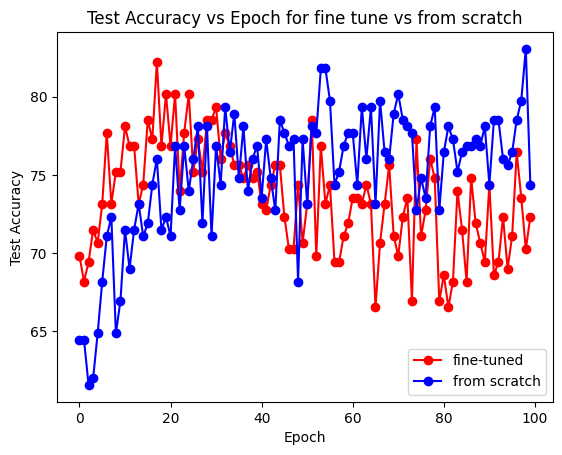

In [ ]:
import matplotlib.pyplot as plt

# COMPLETE THE PLOT FUNCTION HERE

plt.plot(test_acc_list_ft, label='fine-tuned', color = 'red', marker = 'o')
plt.plot(test_acc_list_sc, label='from scratch', color = 'blue', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.title('Test Accuracy vs Epoch for fine tune vs from scratch')
plt.show()

I have also decided to add the results I have obtained for 10 epochs here for reference purposes

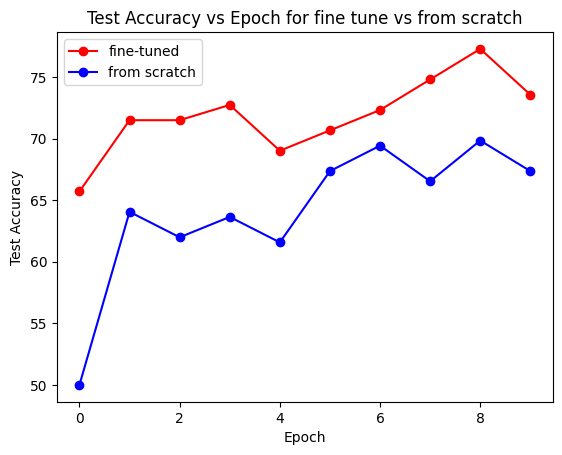

# A3 Task 5 and 6 (2 points) Computing sequence embedding

Task 5 (1 point): Modify `infer_loop` function so that it computes the sequence-level embedding by doing a global average pooling over the embedding of the nucleotide tokens and return the sequence embedding. For instance, embedding of 4 sequences each containig 500 tokens and 128 embedding dimension of 4, 500, 128. By doing a global averaging pooling, the resulting dimension should be 4 by 128.

Task 6 (1 point): The `inference` function below can only infer sequence embedding using a pre-trained hyenadna-tiny-1k-seqlen model. Modify it so that you can enable the function to infer sequence embedding using
1. pre-trained and fine-tuned hyenadna-tiny-1k-seqlen from Task 3
2. trained from scratch hyenadna-tiny-1k-seqlen from Task 3

The function will need to return the sequence embedding of the 242 test sequences from the dummy_mouse_enhancers_ensembl dataset and the corresponding binary target labels of the 242 test sequences.

Note that the fine-tuned and trained-from-scratched model return only the output of the classification head. You will need to figure out a way to let them return the sequence embedding from the last layer of the Hyena backbone.

All 3 models should return the sequence embedding matrix of dimension 242 by 128.

In [ ]:
#@title Computing sequence embedding
"""
Let's say you want to do inference on a dataset to grab a lot of embeddings,
you can just loop thru a dataloader like this.

"""

import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig

# example, if you want to do look thru a dataloader and get embeddings

# A3 task 5: TO BE MODIFIED
def infer_loop(model, device, test_loader):
    """inference loop."""
    model.eval()
    embeddings_list = []
    labels_list = []

    with torch.inference_mode():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            sequence_embeddings = torch.mean(output, dim=1)  # global average pooling

            embeddings_list.append(sequence_embeddings.cpu())
            labels_list.append(target.cpu())

            # print embedding shape, or do something else here, like save.
            print('embeddings shape', output.shape)


    embeddings = torch.cat(embeddings_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    return embeddings, labels

# A3 task 6: TO BE MODIFIED
def inference(from_scratch = False, pretrained_model_name_given = 'hyenadna-tiny-1k-seqlen'):

    '''
    this selects which backbone to use, and grabs weights/ config from HF
    4 options:
      'hyenadna-tiny-1k-seqlen'   # fine-tune on colab ok
      'hyenadna-small-32k-seqlen'
      'hyenadna-medium-160k-seqlen'  # inference only on colab
      'hyenadna-medium-450k-seqlen'  # inference only on colab
      'hyenadna-large-1m-seqlen'  # inference only on colab
    '''

    pretrained_model_name = pretrained_model_name_given
    from_scratch = from_scratch

    if from_scratch == True:
      pretrained_model_name = None

    else:
      # select model
      pretrained_model_name = pretrained_model_name_given  # use None if training from scratch

    max_lengths = {
        'hyenadna-tiny-1k-seqlen': 1024,
        'hyenadna-small-32k-seqlen': 32768,
        'hyenadna-medium-160k-seqlen': 160000,
        'hyenadna-medium-450k-seqlen': 450000,  # T4 up to here
        'hyenadna-large-1m-seqlen': 1_000_000,  # only A100 (paid tier)
    }

    # let's fix the max_length (to reduce the padding amount, conserves memory)
    max_length = 500

    # data settings:
    # we need to choose the dataset and batch size to loop thru
    dataset_name = 'dummy_mouse_enhancers_ensembl'
    batch_size = 4
    use_padding = True
    rc_aug = False  # reverse complement augmentation
    add_eos = False  # add end of sentence token

    # we need these for the decoder head, if using
    use_head = False
    n_classes = 2  # not used for embeddings only

    # you can override with your own backbone config here if you want,
    # otherwise we'll load the HF one in None
    backbone_cfg = None

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)

    # instantiate the model (pretrained here)
    if pretrained_model_name in ['hyenadna-tiny-1k-seqlen',
                                 'hyenadna-small-32k-seqlen',
                                 'hyenadna-medium-160k-seqlen',
                                 'hyenadna-medium-450k-seqlen',
                                 'hyenadna-large-1m-seqlen']:
        # use the pretrained Huggingface wrapper instead
        model = HyenaDNAPreTrainedModel.from_pretrained(
            './checkpoints',
            pretrained_model_name,
            download=True,
            config=backbone_cfg,
            device=device,
            use_head=use_head,
            n_classes=n_classes,
            from_scratch=from_scratch
        )

    # from scratch
    elif pretrained_model_name is None:
        model = HyenaDNAModel(**backbone_cfg, use_head=use_head, n_classes=n_classes)
#        model = HyenaDNAPreTrainedModel.from_pretrained(
#            './checkpoints',
#            pretrained_model_name,
#            download=True,
#            config=backbone_cfg,
#            device=device,
#            use_head=use_head,
#            n_classes=n_classes,
#            from_scratch=False
#        )
    # create tokenizer

    tokenizer = CharacterTokenizer(
        characters=['A', 'C', 'G', 'T', 'N'],  # add DNA characters, N is uncertain
        model_max_length=max_length + 2,  # to account for special tokens, like EOS
        add_special_tokens=False,  # we handle special tokens elsewhere
        padding_side='left', # since HyenaDNA is causal, we pad on the left
    )

    # Sample small dataloader w/ GenomicBenchmarks

    ds_test = GenomicBenchmarkDataset(
        max_length = max_length,
        use_padding = use_padding,
        split = 'test',
        tokenizer=tokenizer,
        dataset_name=dataset_name,
        rc_aug=rc_aug,
        add_eos=add_eos,
    )

    ds_test = GenomicBenchmarkDataset(
        max_length = max_length,
        use_padding = use_padding,
        split = 'test',
        tokenizer=tokenizer,
        dataset_name=dataset_name,
        rc_aug=rc_aug,
        add_eos=add_eos,
    )

    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

    model.to(device)
    model.eval()

    embeddings, labels = infer_loop(model, device, test_loader)

    return embeddings, labels


Run the inference function and save the embedding of all 3 models and the target labels for the following t-SNE plots.

In [ ]:
seq_emb_sc, targets = inference(fromscratch) # infer using from-scratch model
seq_emb_ft, targets = inference(finetuned) # infer using pre-trained + finet-tuned model
seq_emb_pt, targets = inference() # infer using pre-trained model

Using device: cuda


<ipython-input-9-4320eb123ac8>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_ckpt = torch.load(


No loaded pretrained weights. Model trained from Scratch
already downloaded test-dummy_mouse_enhancers_ensembl
already downloaded test-dummy_mouse_enhancers_ensembl
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape torch.Size([4, 500, 128])
embeddings shape t

In [ ]:
print(seq_emb_sc.shape) # expected: torch.Size([242, 128])
print(seq_emb_ft.shape) # expected: torch.Size([242, 128])
print(seq_emb_pt.shape) # expected: torch.Size([242, 128])
print(targets.shape) # expected: torch.Size([242, 1])
print(targets.sum().item()) # expected: 121 as the number of positive sequences

torch.Size([242, 128])
torch.Size([242, 128])
torch.Size([242, 128])
torch.Size([242, 1])
121


# A3 Task 7 (1 point) visualize the sequence embeddings from the 3 models with t-SNE
Generate 3 t-SNE plots using the sequence embedding from the pre-trained-only, pretrrained + fine-tuned, and trained from scratch model. Your plots may not look the same as the ones below but we should see a slightly better clustering of the sequence embedding from the pretrrained + fine-tuned model compared to the other two models.

You may also train for more epochs in Task 3 (e.g., 100 epochs, which takes about 10 minutes with T4 GPU) to see better clustering from pretrrained + fine-tuned and trained from scratch models.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


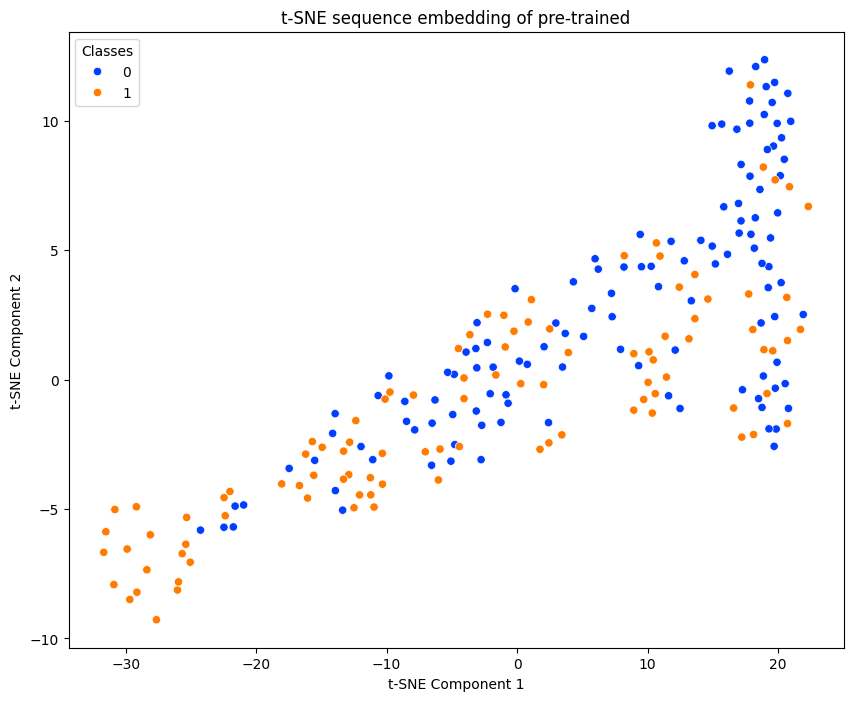

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


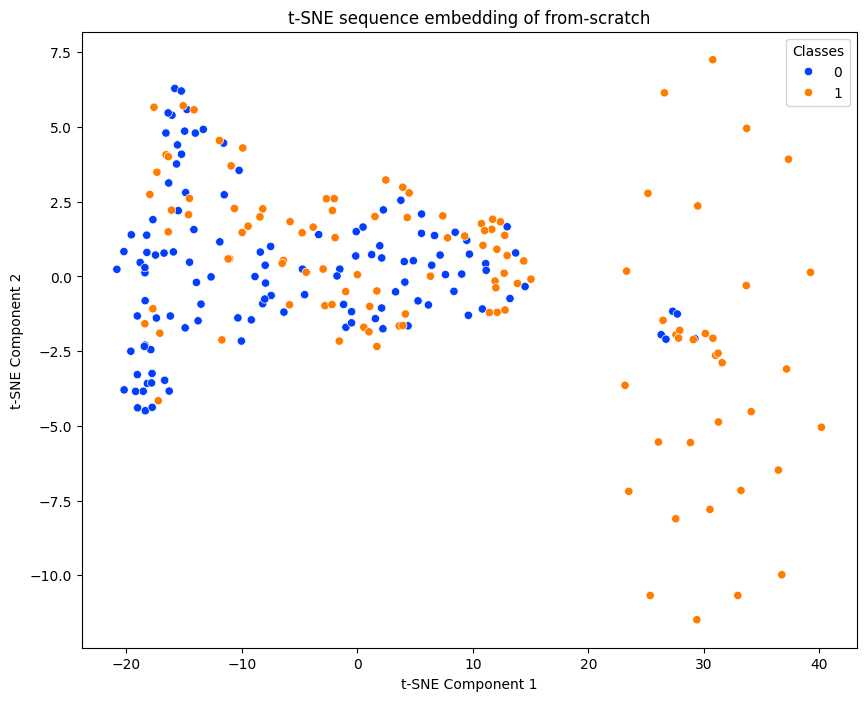

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


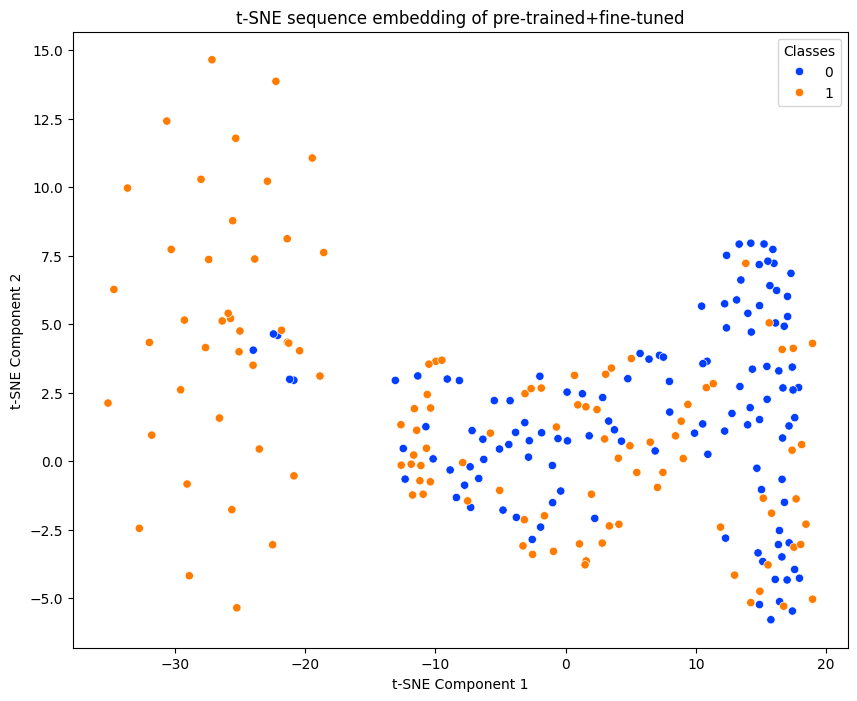

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_emb_tsne(seq_emb, my_title):
  # COMPLETE THIS FUNCTION
  tsne = TSNE(n_components=2, perplexity=30, n_iter = 3000)
  seq_emb_tsne = tsne.fit_transform(seq_emb)
  plt.figure(figsize=(10, 8))
  sns.scatterplot(x=seq_emb_tsne[:, 0], y=seq_emb_tsne[:, 1], hue=targets.flatten(), palette='bright')
  plt.title(my_title)
  plt.xlabel("t-SNE Component 1")
  plt.ylabel("t-SNE Component 2")
  plt.legend(title="Classes", loc='best')
  plt.show()


plot_emb_tsne(seq_emb_pt, my_title="t-SNE sequence embedding of pre-trained")
plot_emb_tsne(seq_emb_sc, my_title="t-SNE sequence embedding of from-scratch")
plot_emb_tsne(seq_emb_ft, my_title="t-SNE sequence embedding of pre-trained+fine-tuned")

# A3 Task 8 (1 point) Autoregressive next token prediction
Lastly we will experiment use a pre-trained HyenaDNA to perform next token prediction on a sequence of ACTB gene (a housekeeping gene in the human and many species). This task is independent from the 7 tasks above.

In [ ]:
from transformers import AutoModelForCausalLM

#@title AutoModelForCausalLM
hyena_model_url = "LongSafari/hyenadna-medium-160k-seqlen-hf"
lm_model = AutoModelForCausalLM.from_pretrained(hyena_model_url, trust_remote_code=True)
lm_model.eval() # uncomment to print the architecture of the pre-traiend HyendaDNA model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/984 [00:00<?, ?B/s]

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.


configuration_hyena.py:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


modeling_hyena.py:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/57.0M [00:00<?, ?B/s]

HyenaDNAForCausalLM(
  (hyena): HyenaDNAModel(
    (backbone): HyenaLMBackbone(
      (embeddings): HyenaEmbeddings(
        (word_embeddings): Embedding(16, 256)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (layers): ModuleList(
        (0-7): 8 x HyenaBlock(
          (mixer): HyenaOperator(
            (dropout): Dropout(p=0.0, inplace=False)
            (in_proj): Linear(in_features=256, out_features=768, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
            (short_filter): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(2,), groups=768)
            (filter_fn): HyenaFilter(
              (dropout): Dropout(p=0.0, inplace=False)
              (pos_emb): HyenaPositionalEmbedding()
              (implicit_filter): Sequential(
                (0): Linear(in_features=5, out_features=64, bias=True)
                (1): HyenaSin()
                (2): Linear(in_features=64, out_features=64, bias=True)
                

Import the ACTB sequence saved in your Google Drive using the SeqIO library. There will be a prompt asking you "Permit this notebook to access your Google Drive files". Click continue and do not check any permission in the new prompt window and click continue again.

In [ ]:
import random
from Bio import SeqIO
from google.colab import drive
drive.mount('/content/drive')

filepath = "/content/drive/My Drive/ACTB_with_promoter_and_introns.fa"
record = SeqIO.read(filepath, "fasta")
ACTB_sequence_id = record.id
ACTB_sequence = str(record.seq).upper()
print(len(ACTB_sequence))
print(ACTB_sequence[:200])

Mounted at /content/drive
4454
GCGGCCTCCAGATGGTCTGGGAGGGCAGTTCAGCTGTGGCTGCGCATAGCAGACATACAACGGACGGTGGGCCCAGACCCAGGCTGTGTAGACCCAGCCCCCCCGCCCCGCAGTGCCTAGGTCACCCACTAACGCCCCAGGCCTTGTCTTGGCTGGGCGTGACTGTTACCCTCAAAAGCAGGCAGCTCCAGGGTAAAAGG


Create a shuffled sequence from the ACTB sequence as a negative control for assessing the next token prediction perplexity.

In [ ]:
# shuffle ACTB
random.seed(42)
shuffle_sequence = lambda sequence: \
  ''.join(random.sample(sequence, len(sequence)))
ACTB_sequence_shuffled = shuffle_sequence(ACTB_sequence)

The function `convert_sequence` converts the string sequence to list of label IDs that HyenaDNA can operate on. The integers 7,  8,  9, 10, 11 correspond to A, C, G, T, and N. The number 0 and 1 correspond to the special tokens of the start of sequence (SOS) and end of sequence (EOS), respectively.

In [ ]:
def convert_sequence(seq):

  # Create tokenizer
  tokenizer = CharacterTokenizer(
      characters=['A', 'C', 'G', 'T', 'N'],  # add DNA characters, N is uncertain
      model_max_length=len(seq) + 2,  # to account for special tokens, like EOS
      add_special_tokens=False,  # we handle special tokens elsewhere
      padding_side='left', # since HyenaDNA is causal, we pad on the left
  )

  # Tokenize sequence (automatically adds start and end)
  ids = tokenizer(seq, return_tensors="pt").input_ids

  # Discard end token from input as we want the model to predict EOS
  input_ids = ids[:,:-1]

  # Discard SOS token from output as the model starts predicting after EOS
  label_ids = ids[:,1:]

  # Flatten labels
  label_ids = label_ids.view(-1).squeeze()

  return input_ids, label_ids

In [ ]:
actb_input_ids, actb_label_ids = convert_sequence(ACTB_sequence)
actb_input_ids_shuffled, actb_label_ids_shuffled = convert_sequence(ACTB_sequence_shuffled)

We can make autoregressive prediction of all nucleotide using the pre-trained HyenaDNA as follows, which outputs the logits (i.e., predictions before the softmax over the nucleotides). This outputs a 4455 by 16 matrix, corresponding to the logistic scores across the vocabulary of size 16. Note that for each token position, only 7, 8, 9, or 10 (i.e., A, C, G, T) is true positive for th ACTB sequence.

In [ ]:
logits = lm_model(actb_input_ids).logits.squeeze(0)
print(logits.shape)

torch.Size([4455, 16])


Complete the function below to compute the perplexity. Perplexity is defined as the exponentiated average negative log-likelihood or equivalently, cross-entropy loss over a set of predictions. In the context of nucleotides or any sequence modeling, perplexity measures how well a probabilistic model predicts the next nucleotide in a sequence.

In [ ]:
import torch.nn.functional as F

def compute_perplexity(model, input_ids, labels_ids):

    # Predict token-level logits from LM model
    logits = model(input_ids).logits.squeeze(0)

    # (optional) you may ignore ambiguous_token 'N' when computing the perplexity
    ambiguous_token_id = 11
    mask = (labels_ids != ambiguous_token_id)

    logits = logits[mask]
    labels_ids = labels_ids[mask]

    loss = F.cross_entropy(logits, labels_ids, reduction='mean')
    perplexity = torch.exp(loss)

    return perplexity


Check the average perplexity of the NTP on the original and shuffled ACTB sequences. The former should be lower than the latter.

In [ ]:
print(f"Original ACTB ppl: {compute_perplexity(lm_model, actb_input_ids, actb_label_ids)}")
print(f"Shuffled ACTB ppl: {compute_perplexity(lm_model, actb_input_ids_shuffled, actb_label_ids_shuffled)}")

Original ACTB ppl: 3.6352474689483643
Shuffled ACTB ppl: 4.0291266441345215
